## Portfolio Optimization and Value at Risk using Monte Carlo and Scipy Optimize



In [3]:
import pandas as pd
import numpy as np 
import yfinance as yf
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
plt.style.use('fivethirtyeight')

In [4]:
tickers = ['META', 'AAPL', 'AMZN', 'GOOG', 'MSFT', 'NVDA', 'TSLA', 'ADBE', 'AMD', 'NFLX']
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2023, 7, 16)
df = yf.download(tickers, start, end)['Adj Close']
df.columns = tickers

[*********************100%***********************]  10 of 10 completed


In [5]:
tickers.sort()

In [8]:
df.head().dropna()

,META,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA,ADBE,AMD,NFLX
Date,,,,,,,,,,
2020-01-02,73.347946,334.429993,49.099998,94.900497,68.368500,209.779999,155.422058,329.809998,59.754215,28.684000
2020-01-03,72.634842,331.809998,48.599998,93.748497,68.032997,208.669998,153.486771,325.899994,58.797791,29.534000
2020-01-06,73.213615,333.709991,48.389999,95.143997,69.710503,212.600006,153.883530,335.829987,59.044365,30.102667
2020-01-07,72.869286,333.390015,48.250000,95.343002,69.667000,213.059998,152.480469,330.750000,59.759197,31.270666
2020-01-08,74.041481,337.869995,47.830002,94.598503,70.216003,215.220001,154.909210,339.260010,59.871281,32.809334


In [10]:
df.tail().dropna()

,META,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA,ADBE,AMD,NFLX
Date,,,,,,,,,,
2023-07-10,188.610001,496.350006,113.580002,127.129997,116.870003,294.100006,331.829987,441.709991,421.799988,269.609985
2023-07-11,188.080002,504.739990,111.320000,128.779999,117.709999,298.290009,332.470001,440.209991,424.049988,269.790009
2023-07-12,189.770004,507.359985,114.580002,130.800003,119.620003,309.339996,337.200012,444.049988,439.019989,271.989990
2023-07-13,190.539993,517.280029,115.919998,134.300003,124.830002,313.410004,342.660004,450.380005,459.769989,277.899994
2023-07-14,190.690002,514.830017,115.940002,134.679993,125.699997,308.869995,345.239990,441.910004,454.690002,281.380005


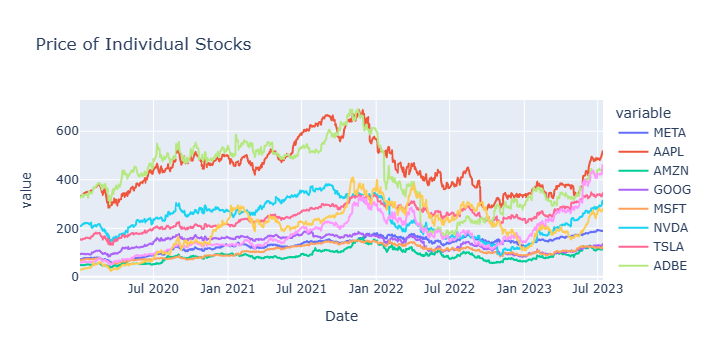

In [17]:
px.line(df, title='Price of Individual Stocks')

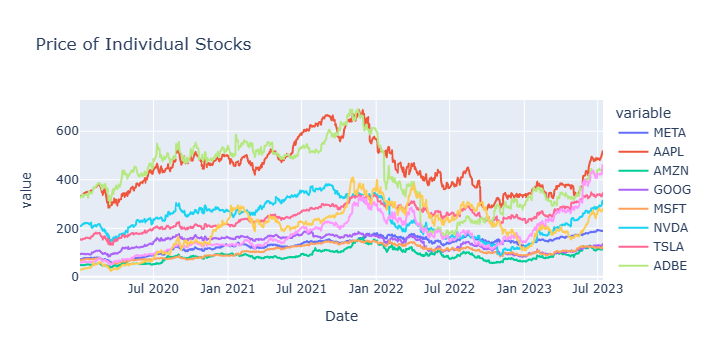

In [18]:
stock_price = px.line(df, title='Price of Individual Stocks')
stock_price.show()

In [26]:
def calc_opt_port(weights, mean_rets, cov, rf):
    portfolio_return = np.sum(mean_rets*weights)*252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov,weights)))*np.sqrt(252)
    sharpe_ratio =  (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio
def simulate_random_ports(num_portfolios, mean_rets, cov, rf):
    results_matrix = np.zeros((len(mean_rets)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_rets))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_opt_port(weights, mean_rets, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3, i] = weights[j]
    
    results_df = pd.DataFrame(results_matrix.T, columns = ['returns', 'stdev', 'sharpe'] + [ticker for ticker in tickers])
    
    return results_df
                                                                                           

In [27]:
mean_rets = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 125000
rf = 0.04
results_frame = simulate_random_ports(num_portfolios, mean_rets, cov, rf)

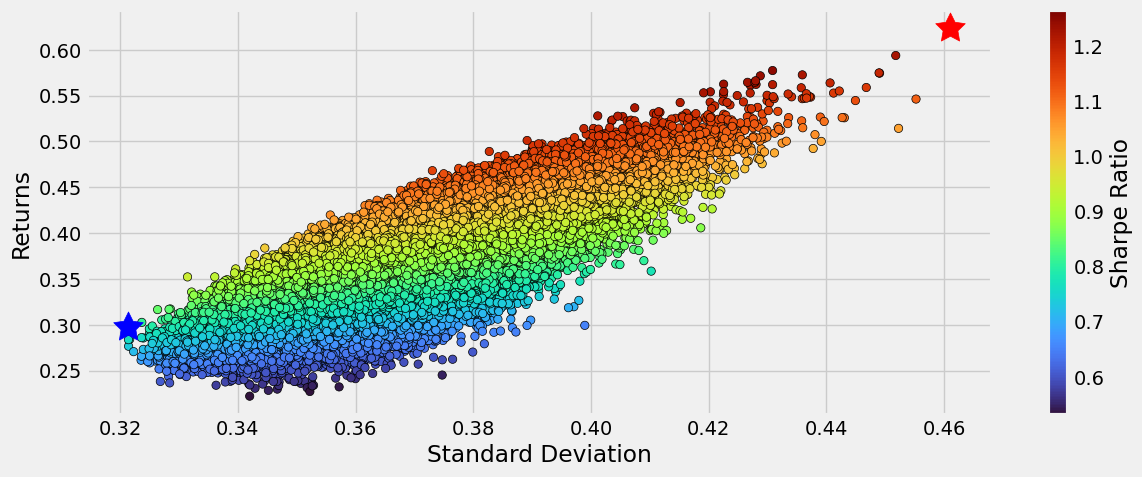

In [40]:
# To locate the position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

# To locate the position of port with minimum std
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

# Create a scatter plot colored by sharpe ratio

plt.subplots(figsize=(13,5))
plt.scatter(results_frame.stdev, results_frame.returns, c=results_frame.sharpe, edgecolors="black", cmap='turbo')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')

#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5,1,0), color='r', s=500)

#plot blue star to highlight position of minimum vol portfolio
plt.scatter(min_vol_port[1], min_vol_port[0], marker=(5,1,0), color='b', s=500)
plt.show()

In [41]:
max_sharpe_port.to_frame().T

,returns,stdev,sharpe,AAPL,ADBE,AMD,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA
16542,0.623735,0.461059,1.266074,0.095107,0.014603,0.110338,0.057463,0.091598,0.005942,0.00432,0.001514,0.263174,0.355941


In [42]:
min_vol_port.to_frame().T

,returns,stdev,sharpe,AAPL,ADBE,AMD,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA
94123,0.297971,0.321343,0.802791,0.277748,0.008327,0.017662,0.152707,0.106718,0.020855,0.351872,0.019518,0.018114,0.026477


In [44]:
def calc_neg_sharpe(weights, mean_rets, cov, rf):
    portfolio_return = np.sum(mean_rets*weights)*252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))*np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf)/portfolio_std
    return -sharpe_ratio
constraints = ({'type':'eq', 'fun':lambda x: np.sum(x) -1})
def max_sharpe_ratio(mean_rets, cov, rf):
    num_assets = len(mean_rets)
    args = (mean_rets, cov, rf)
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x) -1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_rets, cov, rf)

In [45]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']], index=tickers).T

,AAPL,ADBE,AMD,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57,0.43


In [46]:
def calc_portfolio_opt_VaR(weights, mean_rets, cov, alpha, days):
    portfolio_return = np.sum(mean_rets*weights)*days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov,weights)))*np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std*stats.norm.ppf(1-alpha)))
    return portfolio_return, portfolio_std, portfolio_var
def simulate_random_portfolios_VaR(num_portfolios, mean_rets, cov, alpha, days):
    results_matrix = np.zeros((len(mean_rets)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_rets))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_var = calc_portfolio_opt_VaR(weights, mean_rets, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_var
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3, i] = weights[j]
    
    results_df = pd.DataFrame(results_matrix.T, columns = ['returns', 'stdev', 'VaR'] + [ticker for ticker in tickers])
    
    return results_df

In [47]:
mean_rets = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 150000
rf = 0.04
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_rets, cov, alpha, days)

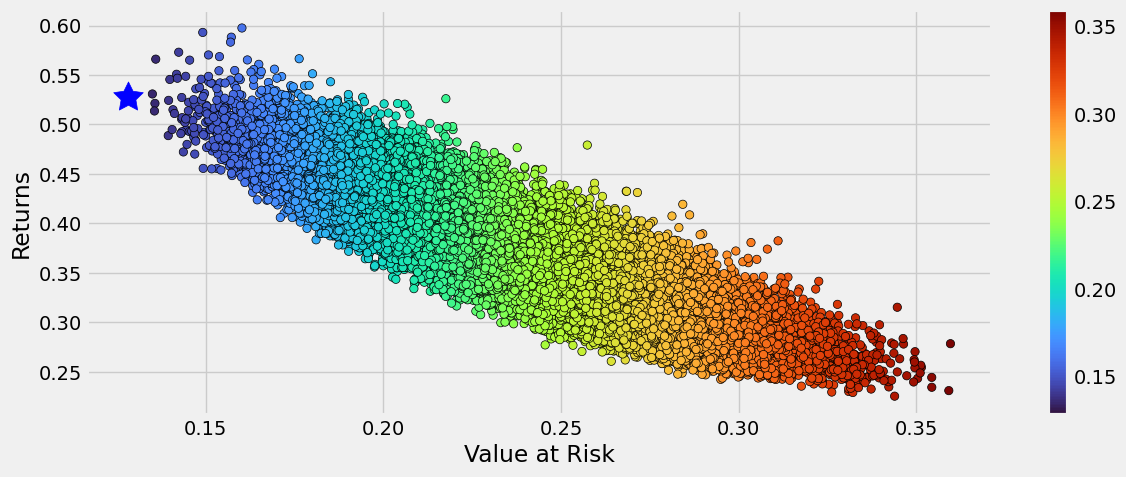

In [48]:
# Locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
# Create a scatter plot colored by VaR
plt.subplots(figsize=(13,5))
plt.scatter(results_frame.VaR, results_frame.returns, c=results_frame.VaR, edgecolors="black", cmap='turbo')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
# plot blue star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2], min_VaR_port[0], marker = (5,1,0), color = 'b', s=500)

In [49]:
min_VaR_port.to_frame().T

,returns,stdev,VaR,AAPL,ADBE,AMD,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA
53424,0.52745,0.398546,0.1281,0.136024,0.000882,0.012918,0.001484,0.167937,0.029007,0.188046,0.005705,0.206202,0.251793


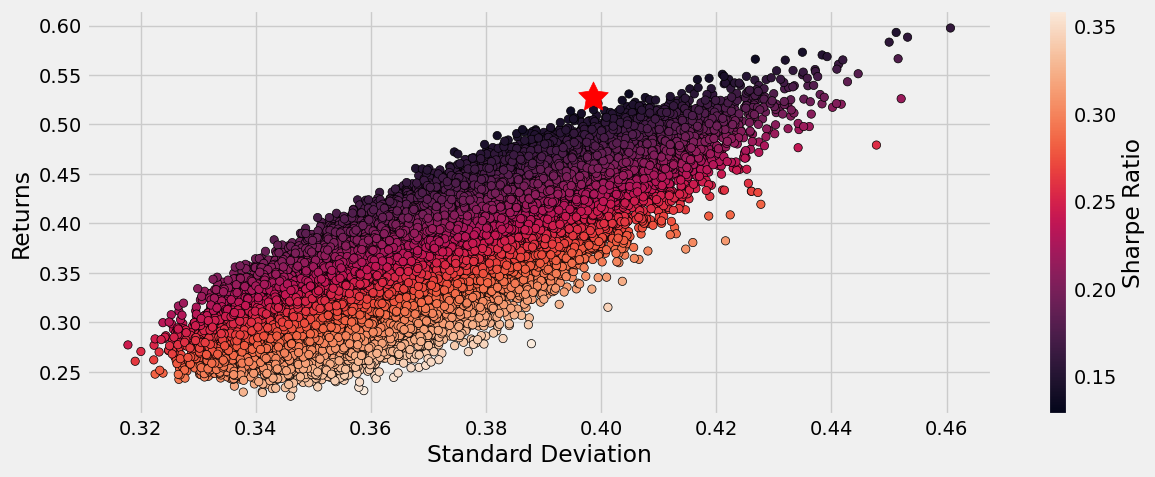

In [50]:
# To locate the minimum VaR portfolio on rets/std/sharpe ratio plot

min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]

# Create scatter plot colored by VaR
plt.subplots(figsize=(13,5))
plt.scatter(results_frame.stdev, results_frame.returns, c=results_frame.VaR, edgecolors="black", cmap='rocket')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')

# plot red star to highlight position of minimum VaR portfolio

plt.scatter(min_VaR_port[1], min_VaR_port[0], marker=(5,1,0), color='r', s=500)

In [51]:
constraints = ({'type':'eq', 'fun':lambda x: np.sum(x) -1})
def calc_portfolio_VaR(weights, mean_rets, cov, alpha, days):
    portfolio_return = np.sum(mean_rets*weights)*252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))*np.sqrt(252)
    portfolio_var = abs(portfolio_return - (portfolio_std*stats.norm.ppf(1-alpha)))
    return portfolio_var
def min_VaR(mean_rets, cov, alpha, days):
    num_assets = len(mean_rets)
    args = (mean_rets, cov, alpha, days)
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x) -1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_VaR = min_VaR(mean_rets, cov, alpha, days)

In [52]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']], index=tickers).T

,AAPL,ADBE,AMD,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA
0,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.37
